# Pr√°ctica 2: An√°lisis de Sentimientos Supervisado y No Supervisado

### Autor: Taisiia Prymak & Jiahui Chen

En esta pr√°ctica se abordar√° el an√°lisis de sentimientos desde dos enfoques principales: supervisado y no supervisado. El contenido se divide en las siguientes secciones:

1. **Preprocesamiento de Datos**: Se realiza una limpieza y transformaci√≥n de los datos textuales para facilitar su an√°lisis. Esto incluye la eliminaci√≥n de ruido, lematizaci√≥n y etiquetado POS (Part-of-Speech).

2. **Modelos Supervisados**: Se entrenan y eval√∫an modelos supervisados como KNN, Random Forest y SVM para clasificar los documentos en funci√≥n de su polaridad. Se utiliza GridSearchCV para optimizar los hiperpar√°metros y se eval√∫an las m√©tricas de rendimiento.

3. **Modelos No Supervisados**: Se exploran m√©todos no supervisados para determinar la polaridad de los textos bas√°ndose en recursos l√©xicos como SentiWordNet.

4. **An√°lisis de Resultados**: Se comparan los resultados obtenidos con ambos enfoques, destacando las ventajas y limitaciones de cada uno.

In [47]:
import nltk
import random
from nltk.corpus import movie_reviews as mr
from sklearn.feature_extraction.text import CountVectorizer

Miramos como es el fichero:

In [48]:
print(len(mr.fileids()) )#hay 2000 ficheros (1000 exemples positius i 1000 negatius)
print(mr.words('pos/cv000_29590.txt'))
print(mr.categories())
print(mr.fileids('pos')) #lista todos los ficheros positivos
print((list(mr.words('pos/cv000_29590.txt')), 'pos') )

2000
['films', 'adapted', 'from', 'comic', 'books', 'have', ...]
['neg', 'pos']
['pos/cv000_29590.txt', 'pos/cv001_18431.txt', 'pos/cv002_15918.txt', 'pos/cv003_11664.txt', 'pos/cv004_11636.txt', 'pos/cv005_29443.txt', 'pos/cv006_15448.txt', 'pos/cv007_4968.txt', 'pos/cv008_29435.txt', 'pos/cv009_29592.txt', 'pos/cv010_29198.txt', 'pos/cv011_12166.txt', 'pos/cv012_29576.txt', 'pos/cv013_10159.txt', 'pos/cv014_13924.txt', 'pos/cv015_29439.txt', 'pos/cv016_4659.txt', 'pos/cv017_22464.txt', 'pos/cv018_20137.txt', 'pos/cv019_14482.txt', 'pos/cv020_8825.txt', 'pos/cv021_15838.txt', 'pos/cv022_12864.txt', 'pos/cv023_12672.txt', 'pos/cv024_6778.txt', 'pos/cv025_3108.txt', 'pos/cv026_29325.txt', 'pos/cv027_25219.txt', 'pos/cv028_26746.txt', 'pos/cv029_18643.txt', 'pos/cv030_21593.txt', 'pos/cv031_18452.txt', 'pos/cv032_22550.txt', 'pos/cv033_24444.txt', 'pos/cv034_29647.txt', 'pos/cv035_3954.txt', 'pos/cv036_16831.txt', 'pos/cv037_18510.txt', 'pos/cv038_9749.txt', 'pos/cv039_6170.txt', 'pos/cv

# Particion Train y Test

In [49]:
doc_pos = [mr.words(f) for f in mr.fileids('pos')]
doc_neg = [mr.words(f) for f in mr.fileids('neg')]

In [50]:
random.shuffle(doc_pos)
random.shuffle(doc_neg)

In [51]:
train_pos = doc_pos[:int((len(doc_pos)*0.7))] #70% para el train
test_pos = doc_pos[int((len(doc_pos)*0.7)):] #30% final para el test

train_neg = doc_neg[:int((len(doc_neg)*0.7))]
test_neg = doc_neg[int((len(doc_neg)*0.7)):]

In [52]:
train = train_pos + train_neg
test = test_pos + test_neg

In [53]:
print(len(train_pos), len(train_neg))
print(len(test_pos), len(test_neg))

700 700
300 300


In [54]:
train_labels = [1]*700 + [0]*700
print(len(train_labels))
test_labels = [1]*300 + [0]*300

1400


# Preprocesamiento


In [55]:
import re

def preproces(text):
    text_clean = []
    # Expresi√≥n regular para eliminar todo lo que no sea una letra o un espacio
    regex = r"[^a-zA-Z\s]"
    
    # Diccionario de reemplazo
    replacements = {
        "t": "not",
        's': 'is', #aunque tambien puede ser posesivo
        "didn": "did",
        "haven": "have",
        "hasn": "has",
        "hadn": "had",
        "shouldn": "should",
        "wouldn": "would",
        "couldn": "could",
        "mustn": "must",
        'doesn': 'does',
        'isn' : 'is',
        'aren' : 'are',
        'll': 'will',
        've' : 'have', 
        'd' : 'would',
        'm': 'am'
    }
    
    for w in text:
        # Eliminar caracteres no deseados y n√∫meros
        limpio = re.sub(regex, "", w)
        # Convertir a min√∫sculas
        limpio = limpio.lower()
        # Eliminar espacios en blanco al principio y al final
        limpio = limpio.strip()
        
        # Reemplazar si est√° en el diccionario
        if limpio in replacements:
            limpio = replacements[limpio]
        # Filtrar tokens vac√≠os
        if limpio != "":
            text_clean.append(limpio)
    
    return text_clean

In [56]:
clean_train = [preproces(words) for words in train]
print(clean_train[0])
clean_test = [preproces(words)for words in test]

['i', 'have', 'seen', 'several', 'but', 'not', 'that', 'many', 'woody', 'allen', 'movies', 'i', 'did', 'not', 'particulary', 'like', 'radio', 'days', 'the', 'purple', 'rose', 'of', 'cairo', 'play', 'it', 'again', 'sam', 'i', 'quite', 'enjoyed', 'manhatten', 'murder', 'mystery', 'and', 'everything', 'sex', 'and', 'i', 'loved', 'might', 'aphrodite', 'however', 'i', 'found', 'bullets', 'over', 'broadway', 'to', 'be', 'a', 'snoozing', 'bore', 'and', 'bullets', 'got', 'some', 'very', 'raving', 'reviews', 'but', 'i', 'did', 'not', 'think', 'i', 'would', 'like', 'but', 'i', 'finally', 'saw', 'it', 'double', 'feature', 'with', 'ready', 'to', 'wear', 'i', 'think', 'and', 'hated', 'it', 'since', 'i', 'love', 'you', 'also', 'seems', 'to', 'be', 'getting', 'raving', 'reviews', 'i', 'wasn', 'not', 'sure', 'if', 'i', 'would', 'want', 'to', 'see', 'thankfully', 'i', 'did', 'people', 'burst', 'into', 'singing', 'and', 'dancing', 'something', 'i', 'hardly', 'ever', 'like', 'but', 'this', 'movie', 'is',

## Lematizaci√≥n

Lematizamos para reducir la dimensionalidad del vector CountVectorizer y generalizar las palabras, unificando diferentes formas de una misma palabra en su forma base o lema. Esto permite que el an√°lisis sea m√°s eficiente y preciso al trabajar con un vocabulario reducido y normalizado.

In [57]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\jiahu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

Poner tags y no incluir stop Words ya que no aportaran informaci√≥n relevante para el Sentiment Analisys:

In [58]:

def tagger(clean_train):
    train_tagged = []
    tags = set()
    stop_tags = {'DT', 'IN', 'CC', 'PRP', 'PRP$', 'WP', 'WP$', 'RP', 'TO', 'CD', 'EX', 'WDT'}
    for l in clean_train:
        aux = []
        con_tag = nltk.pos_tag(l)
        for w, tag in con_tag:
            if tag not in stop_tags:
                aux.append((w, tag))
                tags.add(tag)
        train_tagged.append(aux)
    return train_tagged, tags

train_tagged, tags = tagger(clean_train)
test_tagged, _ = tagger(clean_test)

In [59]:
print(tags) #todos los tags unicos que aparecen en el train

{'NN', 'FW', 'PDT', 'JJR', 'NNP', 'JJS', 'NNS', 'SYM', 'WRB', 'VBD', '$', 'VBG', 'RB', 'VBP', 'VBN', 'POS', 'NNPS', 'MD', 'RBR', 'VB', 'VBZ', 'RBS', 'JJ', 'UH'}


In [60]:
#ejemplo del resultado
print(train_tagged[0])
print(train[0]) 

[('i', 'NNS'), ('have', 'VBP'), ('seen', 'VBN'), ('several', 'JJ'), ('not', 'RB'), ('many', 'JJ'), ('woody', 'NN'), ('allen', 'JJ'), ('movies', 'NNS'), ('i', 'VBP'), ('did', 'VBD'), ('not', 'RB'), ('particulary', 'JJ'), ('radio', 'NN'), ('days', 'NNS'), ('purple', 'NN'), ('rose', 'VBD'), ('cairo', 'JJ'), ('play', 'NN'), ('again', 'RB'), ('sam', 'VBD'), ('i', 'JJ'), ('quite', 'RB'), ('enjoyed', 'JJ'), ('manhatten', 'NN'), ('murder', 'NN'), ('mystery', 'NN'), ('everything', 'NN'), ('sex', 'NN'), ('i', 'NN'), ('loved', 'VBD'), ('might', 'MD'), ('aphrodite', 'VB'), ('however', 'RB'), ('i', 'JJ'), ('found', 'VBN'), ('bullets', 'NNS'), ('broadway', 'NN'), ('be', 'VB'), ('snoozing', 'NN'), ('bore', 'NN'), ('bullets', 'NNS'), ('got', 'VBD'), ('very', 'RB'), ('raving', 'JJ'), ('reviews', 'NNS'), ('i', 'NN'), ('did', 'VBD'), ('not', 'RB'), ('think', 'VB'), ('i', 'RB'), ('would', 'MD'), ('like', 'VB'), ('i', 'VB'), ('finally', 'RB'), ('saw', 'VBD'), ('double', 'JJ'), ('feature', 'NN'), ('ready', 

In [61]:
#ver otros ejemplos de palabras con un cierto tag
palabras = []
for l in train_tagged:
    for palabra, etiqueta in l:
            if etiqueta == '$':
                palabras.append(palabra)
print(palabras)

['lambs', 'ten']


El tag '$' es un error del tagger pero vemos que no supondr√° ning√∫n problema.

Adem√°s, al observar el tag "FW" (palabras que se etiquetan como extranjeras) vemos que podr√≠amos eliminar errores, palabras en otros idiomas, nombres propios, pero tambi√©n palabras normales.

Como posteriormnte se va a hacer filtrado de frequencias esperamos que se eliminar√°n las palabras no deseadas y quedar√°n las que s√≠ que tienen sentido.

Acontinuaci√≥n, se lematizan solo estas categorias, reconocidas por SentiWordNet:

* **Sustantivos ('n'):**    'NN', 'NNS', 'NNP', 'NNPS'
* **Verbos ('v'):**     'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'
* **Adjetivos ('a'):**  'JJ', 'JJR', 'JJS'
* **Adverbios ('r'):**  'RB', 'RBR', 'RBS'

In [62]:
wnl = nltk.stem.WordNetLemmatizer()

def lemmatize(p):
  d = {'NN': 'n', 'NNS': 'n', 'NNP' : 'n', 'NNPS':'n', #sustantivos
       'JJ': 'a', 'JJR': 'a', 'JJS': 'a',  #adjetivos 
       'VB': 'v', 'VBD': 'v', 'VBG': 'v', 'VBN': 'v', 'VBP': 'v', 'VBZ': 'v', 'MD':'v', #verbos
       'RB': 'r', 'RBR': 'r', 'RBS': 'r'}  #adverbios
  if p[1] in d:
    return wnl.lemmatize(p[0], pos=d[p[1]])
  return p[0]

In [63]:
def lemmatize_tagged(train_tagged):    
    train_lemat = []
    for l in train_tagged:
        aux = []
        for i in l:
            aux.append(lemmatize(i))
        train_lemat.append(aux)
    return train_lemat

train_lemat = lemmatize_tagged(train_tagged)
test_lemat = lemmatize_tagged(test_tagged)

## Vectroizaci√≥n BoW

Aunque la vectorizaci√≥n se ejecutar√° junto con el entrenamiento de los modelos, primero se realiza una vectorizaci√≥n inicial para explorar la distribuci√≥n de frecuencias de las palabras y ajustar los par√°metros del vectorizador. En este apartado se incluyen los siguientes pasos:

1. **Vectorizaci√≥n inicial**: Se utiliza `CountVectorizer` para transformar los documentos en una matriz de frecuencias de t√©rminos.
2. **Distribuci√≥n de frecuencias**: Se calcula y visualiza la distribuci√≥n de frecuencias de las palabras en el conjunto de entrenamiento.
3. **Eliminaci√≥n de frecuencias bajas**: Se filtran las palabras con frecuencias bajas para reducir el ruido y mejorar el rendimiento de los modelos.
4. **Vectorizaci√≥n final**: Se aplica la vectorizaci√≥n con los par√°metros ajustados para preparar los datos para el entrenamiento de los modelos supervisados.

In [64]:
vectorizer = CountVectorizer()
train_aplanado = [' '.join(sublista) for sublista in train_lemat]
X_train = vectorizer.fit_transform(train_aplanado)

In [65]:
X_train.shape

(1400, 27650)

Eliminacion de frequencias bajas.

In [66]:
# Sumamos las frecuencias de cada palabra en todos los documentos
word_frequencies = X_train.sum(axis=0).A1
# Obtenemos el vocabulario mapeado a √≠ndices
words = vectorizer.get_feature_names_out()
# Convertimos en un diccionario {palabra: frecuencia}
freq_dict = dict(zip(words, word_frequencies))
# Ordenamos por frecuencia ascendente
sorted_freq = sorted(freq_dict.items(), key=lambda x: x[1])
print(sorted_freq[:10])  # Muestra las 10 palabras menos frecuentes


[('aaaaaaaahhhh', np.int64(1)), ('aaaahhhs', np.int64(1)), ('aahs', np.int64(1)), ('aamir', np.int64(1)), ('aardman', np.int64(1)), ('aatish', np.int64(1)), ('abate', np.int64(1)), ('abberation', np.int64(1)), ('abbots', np.int64(1)), ('abbott', np.int64(1))]


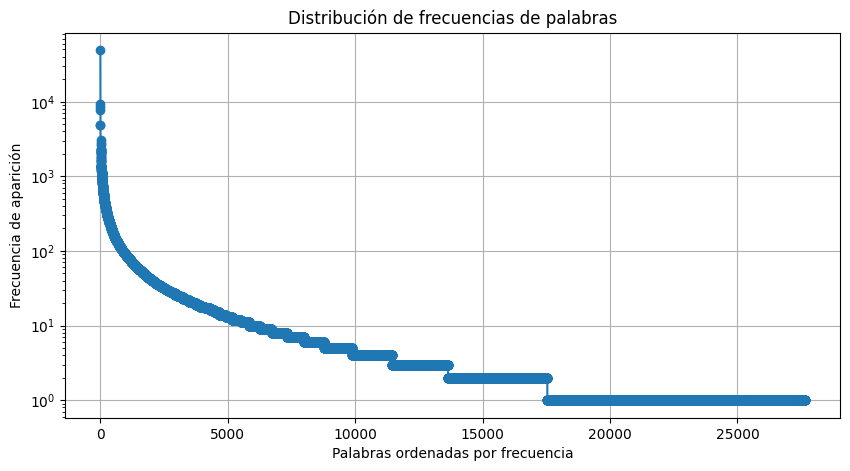

In [67]:
import matplotlib.pyplot as plt
import numpy as np

# Ordenamos las frecuencias en orden descendente para mejor interpretacion de la grafica
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gr√°fica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")

plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparici√≥n")
plt.title("Distribuci√≥n de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

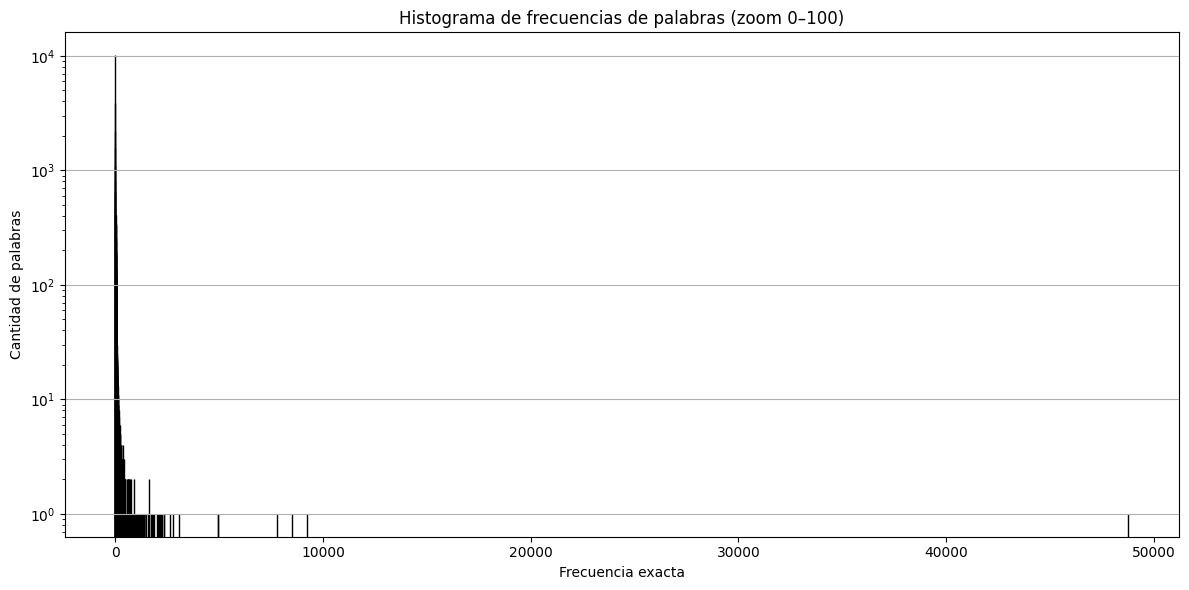

In [68]:

max_freq = int(max(word_frequencies))

plt.figure(figsize=(12,6))
plt.hist(word_frequencies, bins=np.arange(1, max_freq + 1), edgecolor='black', log=True)

plt.xlabel("Frecuencia exacta")
plt.ylabel("Cantidad de palabras")
plt.title("Histograma de frecuencias de palabras (zoom 0‚Äì100)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Viendo la gr√°fica, podemos observar que la mayor√≠a de las palabras tienen una frecuencia de aparici√≥n muy baja. Por lo tanto, si seleccionamos un valor alto para `min_freq`, eliminar√≠amos demasiados datos relevantes. Por esta raz√≥n, se ha optado por un valor de `min_freq = 3`, que permite conservar un equilibrio entre eliminar ruido y mantener informaci√≥n √∫til.


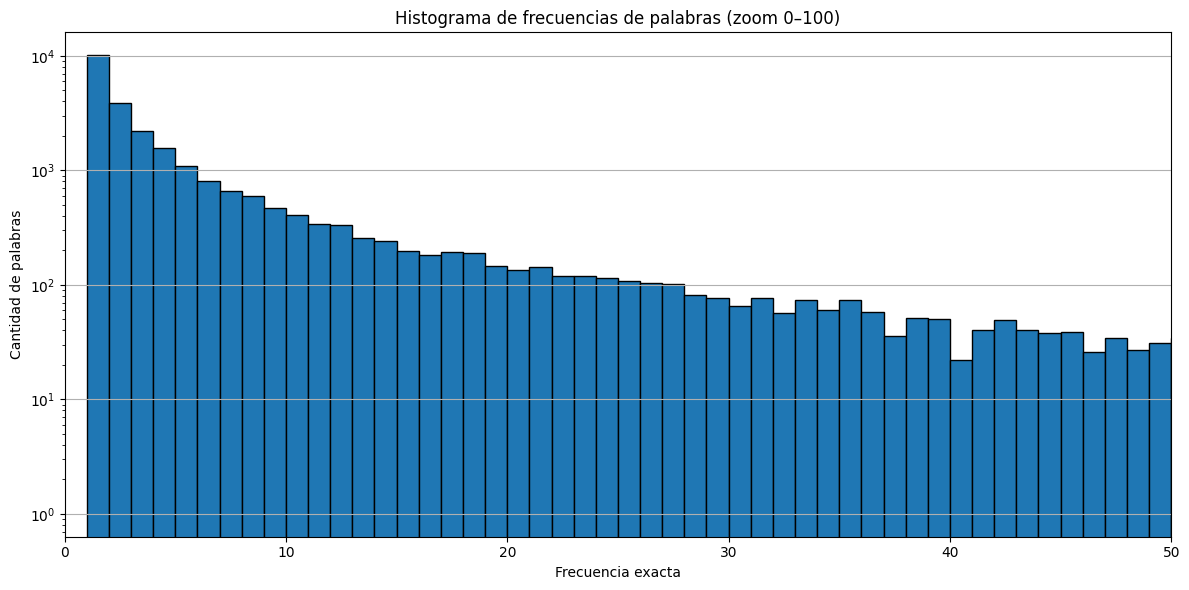

In [69]:
plt.figure(figsize=(12,6))
plt.hist(word_frequencies, bins=np.arange(1, max_freq + 1), edgecolor='black', log=True)

plt.xlabel("Frecuencia exacta")
plt.ylabel("Cantidad de palabras")
plt.title("Histograma de frecuencias de palabras (zoom 0‚Äì100)")
plt.grid(axis='y')
# üîç Zoom en el eje X
plt.xlim(0, 50)
plt.tight_layout()
plt.show()

In [70]:
min_freq = 3  # Umbral m√≠nimo (si se pone mas agrande se eliminaran mas de la mitad de las observaciones)
vectorizer = CountVectorizer(min_df=min_freq)
X_filtered = vectorizer.fit_transform(train_aplanado)

Distribuci√≥n de frequencias filtrada:

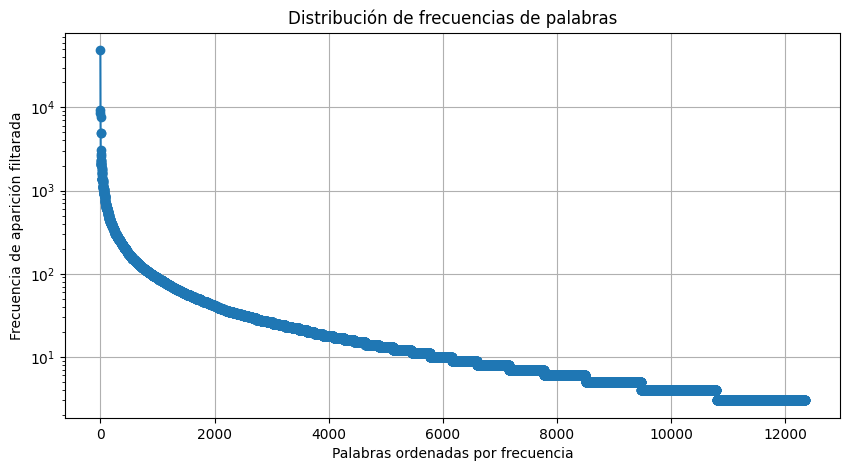

In [71]:
word_frequencies = X_filtered.sum(axis=0).A1
sorted_freq_values = np.array(sorted(word_frequencies, reverse=True))

# Creamos la gr√°fica
plt.figure(figsize=(10,5))
plt.plot(sorted_freq_values, marker="o", linestyle="-")
plt.xlabel("Palabras ordenadas por frecuencia")
plt.ylabel("Frecuencia de aparici√≥n filtarada")
plt.title("Distribuci√≥n de frecuencias de palabras")
plt.yscale("log") 
plt.grid()

In [72]:
X_filtered.shape #train final

(1400, 12346)

# Modelos supervisados. Parte 1:

Una vez que los datos han sido preprocesados para facilitar la clasificaci√≥n de los documentos, se procede a construir los modelos supervisados.

En esta pr√°ctica, se comparan tres modelos supervisados con enfoques significativamente diferentes: **KNN**, **Random Forest** y **SVM (Support Vector Machine)**. Para garantizar una evaluaci√≥n justa, se sigue el mismo procedimiento de entrenamiento para cada modelo:

1. **Optimizaci√≥n de Hiperpar√°metros**: Se utiliza la funci√≥n **GridSearchCV**, que entrena los modelos con diferentes particiones de **train** y **validation**, para encontrar los mejores par√°metros que se ajusten a los datos de entrenamiento.

2. **Evaluaci√≥n con Cross-Validation**: Una vez seleccionados los mejores par√°metros, se aplica la funci√≥n **cross_validate** para calcular m√©tricas de rendimiento como accuracy, F1-score, precisi√≥n y recall, utilizando diferentes *folds*.

3. **Predicci√≥n con el test**: Una vez tenemos los modelos entrenados, los validamos con el dataset test.

In [73]:
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd

# datos
X = train_aplanado
y = train_labels

# M√©tricas que quieres evaluar
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Resultados globales
resultados = {}

# ----------- MODELO 1: KNN -----------
pipe_knn = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', KNeighborsClassifier())
])

param_knn = {
    'clf__n_neighbors': [3, 5, 7]
}

grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=5, scoring='accuracy')
grid_knn.fit(X, y)

mejor_knn = grid_knn.best_estimator_

# ----------- MODELO 2: Random Forest -----------
pipe_rf = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', RandomForestClassifier(random_state=42))
])

param_rf = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10, 100]
}

grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=5, scoring='accuracy')
grid_rf.fit(X, y)
mejor_rf = grid_rf.best_estimator_

# ----------- MODELO 3: SVM -----------
pipe_svm = Pipeline([
    ('vectorizer', CountVectorizer(min_df=3)),
    ('clf', SVC())
])

param_svm = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(pipe_svm, param_grid=param_svm, cv=5, scoring='accuracy')
grid_svm.fit(X, y)
mejor_svm = grid_svm.best_estimator_

Se evaluaron los modelos supervisados (KNN, Random Forest y SVM) con `cross_validate` usando m√©tricas como `accuracy`, `f1_macro`, `precision_macro` y `recall_macro`.

KNN mostr√≥ el peor rendimiento en todas las m√©tricas debido a su ineficiencia en datos de alta dimensionalidad, por lo que no es adecuado. Random Forest logr√≥ un buen equilibrio entre precisi√≥n y recall, siendo una opci√≥n s√≥lida. SVM destac√≥ como el mejor modelo, obteniendo los mejores resultados en `accuracy` y `f1_macro`.

**Modelo Ganador**

SVM es el modelo m√°s efectivo, superando ligeramente a Random Forest en precisi√≥n y F1-score.


In [74]:
# Diccionario de modelos a comparar
modelos = {
    "KNN": mejor_knn,
    "RandomForest": mejor_rf,
    "SVM": mejor_svm
}

# Guardamos resultados
resultados = {}

# mejor_knn, mejor_rf, mejor_svm son Pipelines que contienen el mejor modelo y el vectorizador. 
for nombre, modelo in modelos.items():
    cv_result = cross_validate(modelo, X, y, cv=5, scoring=scoring)

    resumen = {m√©trica: round(cv_result[f'test_{m√©trica}'].mean(), 4) for m√©trica in scoring}
    resultados[nombre] = resumen


# Mostrar como DataFrame ordenado
df_resultados = pd.DataFrame(resultados).T
print("üîç Los mejores resultados de cada modelo:")
print(df_resultados)


üîç Los mejores resultados de cada modelo:
              accuracy  f1_macro  precision_macro  recall_macro
KNN             0.6064    0.6005           0.6127        0.6064
RandomForest    0.8064    0.8060           0.8092        0.8064
SVM             0.8150    0.8149           0.8158        0.8150


## Aplicaci√≥n al *test*

Despu√©s de obtener cada modelo con sus mejores par√°metros a trav√©s de **GridSearch**, predecimos con estos modelos para los datos del test y obtenemos a partir de all√≠ el accuracy y la matriz de confusi√≥n. 

In [75]:
# Con los mejores modelos entrenados, predecimos sobre el conjunto de test
X_test = [' '.join(sublista) for sublista in test_lemat]
y_test = test_labels

# Predicciones
y_pred_knn = mejor_knn.predict(X_test)
y_pred_rf = mejor_rf.predict(X_test)
y_pred_svm = mejor_svm.predict(X_test)

# Accuracy
acc_knn = mejor_knn.score(X_test, y_test)
acc_rf = mejor_rf.score(X_test, y_test)
acc_svm = mejor_svm.score(X_test, y_test)

# Matriz de Confusi√≥n
from sklearn.metrics import confusion_matrix

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)


Observamos que el modelo que ha obtenido el mejor resultado es el SVM, el Random Forest tambi√©n ha obtenido resultados similares, el KNN s√≠ que no ha obtenido resultados muy buenos.

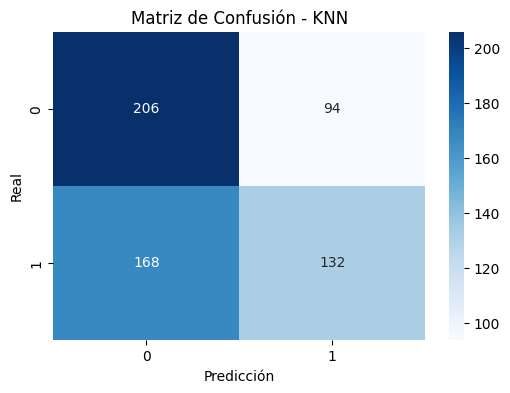

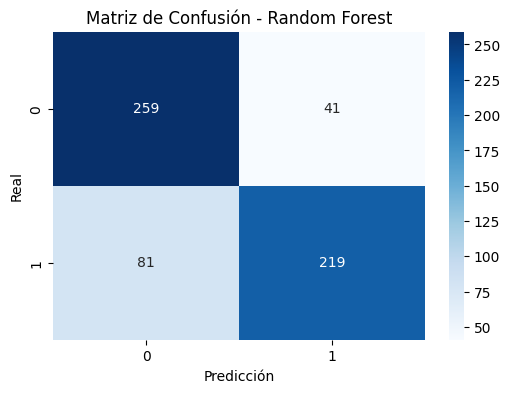

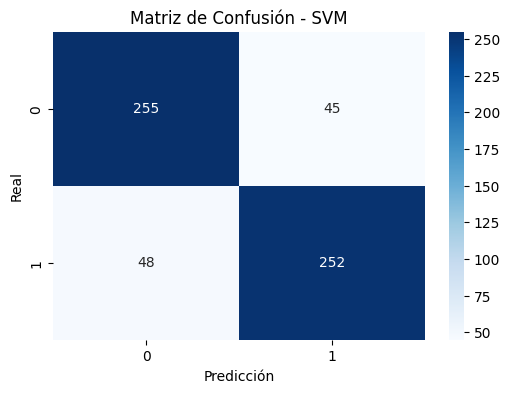

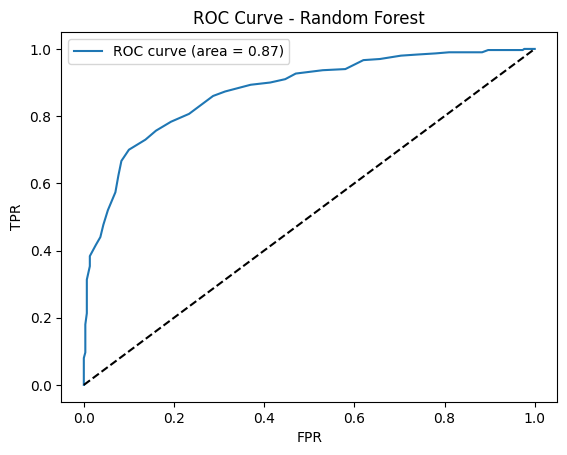

KNN:
               precision    recall  f1-score   support

           0       0.55      0.69      0.61       300
           1       0.58      0.44      0.50       300

    accuracy                           0.56       600
   macro avg       0.57      0.56      0.56       600
weighted avg       0.57      0.56      0.56       600

Random Forest:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       300
           1       0.84      0.73      0.78       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600

SVM:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85       300
           1       0.85      0.84      0.84       300

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.84       600
weighted avg       0.85      0.84      0.84   

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report

model_names = ['KNN', 'Random Forest', 'SVM']
cms = [cm_knn, cm_rf, cm_svm]
preds = [y_pred_knn, y_pred_rf, y_pred_svm]

for i, cm in enumerate(cms):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusi√≥n - {model_names[i]}')
    plt.xlabel('Predicci√≥n')
    plt.ylabel('Real')
    plt.show()

# Solo si es binario:
fpr, tpr, _ = roc_curve(y_test, mejor_svm.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve - Random Forest')
plt.legend()
plt.show()

print("KNN:\n", classification_report(y_test, y_pred_knn))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("SVM:\n", classification_report(y_test, y_pred_svm))

# Crear un diccionario con los accuracies
ranking_dict = {
    'Modelo': ['KNN', 'Random Forest', 'SVM'],
    'Accuracy': [acc_knn, acc_rf, acc_svm]
}

# Crear DataFrame y ordenarlo de mayor a menor
ranking_df = pd.DataFrame(ranking_dict)
ranking_df = ranking_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Mostrar el ranking
print("üìä Ranking de modelos seg√∫n Accuracy:")
print(ranking_df)


# Modelos no supervisados. Parte 2:

En esta secci√≥n se aborda la clasificaci√≥n de polaridad utilizando m√©todos no supervisados basados en recursos l√©xicos como SentiWordNet. El proceso se divide en las siguientes etapas:

1. **Preprocesamiento y Filtrado**: Se seleccionan las palabras m√°s relevantes para el an√°lisis de sentimientos, como adjetivos, verbos, sustantivos y adverbios, y se eliminan aquellas con baja frecuencia.

2. **Obtenci√≥n de Synsets**: Se emplea principalmente el algoritmo de Lesk para identificar los synsets correspondientes a cada palabra en el contexto del documento.

3. **Asignaci√≥n de Puntuaciones**: Se utilizan las puntuaciones de positividad y negatividad de SentiWordNet para calcular la polaridad de cada palabra y, posteriormente, del documento completo.

4. **Manejo de Synsets Ausentes**: Se implementan estrategias para tratar palabras cuyos synsets no est√°n presentes en SentiWordNet, como la propagaci√≥n de puntuaciones desde synsets relacionados o la asignaci√≥n de valores neutros.

5. **Clasificaci√≥n de Polaridad**: Se calcula un score global para cada documento, determinando si su polaridad es positiva, negativa o neutra.

In [77]:
from textserver import TextServer 
#ts = TextServer('jajajajaj', 'Text_2025', 'senses') 
from nltk.wsd import lesk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from collections import Counter

### Preprocesamiento:

Para el preprocesamiento de la segunda parte se han empleado las siguientes medidas:

- Filtrado por etiquetas POS relevantes (diccioanrio de POS que se pasan como un argumento), eliminando palabras que no aportan informaci√≥n √∫til para el an√°lisis de sentimientos.  
- Eliminaci√≥n de palabras con frecuencia menor al umbral `min_freq` para reducir ruido. 


In [78]:
def filtrar_y_limpiar(tagged_docs, etiquetas_validas, min_freq=3):
    # 1. Filtrar por etiquetas v√°lidas
    filtrados_por_pos = [
        [w for w, tag in doc if tag in etiquetas_validas]
        for doc in tagged_docs
    ]

    # 2. Calcular frecuencias globales
    word_freq = Counter()
    for doc in filtrados_por_pos:
        word_freq.update(doc)

    # 3. Eliminar palabras con frecuencia < min_freq
    filtered_words = {word for word, freq in word_freq.items() if freq < min_freq}
    docs_filtrados = [
        [word for word in doc if word not in filtered_words]
        for doc in filtrados_por_pos
    ]

    return docs_filtrados

### Obtenci√≥n de los synsets:

Hemos observado que TextServer es incapaz de detectar algunos synsets pero el algoritmo de Lesk s√≠, por ejemplo:

In [79]:
'''result = ts.senses('lively')[0][0]
print(result)
print(lesk(train_lemat[8], 'lively'))'''

"result = ts.senses('lively')[0][0]\nprint(result)\nprint(lesk(train_lemat[8], 'lively'))"

Por lo tanto, si el algoritmo de UKB es incapaz de encontrar el synset se va a intentar encontrarlo mediante Lesk:

In [80]:
# Algunos ejemplos son capaces de obtener el synset del lesk, pero no del Freeling.
def get_synsets(w, contexto):
    try:
        result = ts.senses(w)[0][0]
        categ = result[4][-1]
        id = int(result[4][0:8])
        synset1 = wn.synset_from_pos_and_offset(categ, id)
        return synset1
    except:
        return lesk(contexto, w) 

Se ha intentado solucionar el problema de senti_synsets no anotados para algunas palabras buscando el synsets de sus sin√≥nimos, pero como que es demasiado costoso, tampoco se ha usado en la funci√≥n del modelo.

In [81]:
#Metodo que incluye la busqueda de sinonimos

def get_synsets2(w, contexto):
    # 1. Intenta obtener el synset directamente con ts.senses
    try:
        result = ts.senses(w)[0][0]
        categ = result[4][-1]
        id = int(result[4][0:8])
        synset = wn.synset_from_pos_and_offset(categ, id)
        return synset
    except:
        pass  # Si falla, pasa al siguiente m√©todo
    
    # 2. Intenta con el algoritmo Lesk
    synset_lesk = lesk(contexto, w)
    if synset_lesk is not None:
        return synset_lesk
    
    # 3. Si todo falla, busca sin√≥nimos y prueba con ellos
    synonyms = set()  
    
    # Obtenemos todos los lemas (sin√≥nimos) de WordNet para la palabra
    for syn in wn.synsets(w):
        for lemma in syn.lemmas():
            synonym = lemma.name().replace("_", " ")  # Limpia guiones bajos
            if synonym.lower() != w:  # Evita la palabra original
                synonyms.add(synonym)
    
    # Probamos cada sin√≥nimo con ts.senses y Lesk
    for synonym in synonyms:
        # Intenta con ts.senses
        try:
            result = ts.senses(synonym)[0][0]
            categ = result[4][-1]
            id = int(result[4][0:8])
            synset = wn.synset_from_pos_and_offset(categ, id)
            return synset
        except:
            pass
        
        # Intenta con Lesk si ts.senses falla
        synset_lesk = lesk(contexto, synonym)
        if synset_lesk is not None:
            return synset_lesk
    
    # Si nada funciona, retorna None 
    return None

#### ¬ø Qu√© ocurre si el synset no est√° en SentiWordnet?

**1)Propagaci√≥n basada en relaciones sem√°nticas**

Utilizar la jerarqu√≠a de WordNet para propagar puntuaciones desde synsets relacionados.
- Buscar sin√≥nimos del synset ausente
- Si se encuentra en SentiWordNet, propagar sus valores al synset ausente

PROBLEMA: El valor estar√° a una distancia sem√°ntica diferente que el valor real

**2)Asignaci√≥n de valores neutros**

Asignar un valor neutral (0) a todos los synsets no encontrados.
Este enfoque asume que las palabras ausentes no contribuyen al sentimiento del texto. SentiWordNet se enfoca en palabras con carga emocional clara, y por tanto, las palabras ausentes probablemente sean neutras en t√©rminos de sentimiento.

- "La ausencia de ciertos t√©rminos en l√©xicos de sentimiento como SentiWordNet puede interpretarse como evidencia de su naturaleza sem√°nticamente neutra en contextos evaluativos" (Baccianella et al., 2010).

### El m√©todo:

Clasificaci√≥n de polaridad siguiendo la siguiente f√≥rmula:

**score(s) = poss ‚àí neg**

Donde *poss* representa el score de positividad y *neg* el score de negatividad.
Cuando la f√≥rmula se aplica a todo un texto, el resultado ser√° un √∫nico valor num√©rico que representa la polaridad global del texto:

- Un valor positivo (+) indica que el texto tiene una tendencia general positiva
- Un valor negativo (-) indica que el texto tiene una tendencia general negativa
- Un valor cercano a cero sugiere que el texto es mayormente neutro

In [89]:

def predecir_sentimiento(lista_docs):
    etiquetas_predichas = []

    for doc in lista_docs:
        pos_s = 0
        neg_s = 0

        for w in doc:
            s1 = get_synsets2(w, doc)
            if s1 is not None:
                try:
                    senti_synset = swn.senti_synset(s1.name())
                    pos_s += senti_synset.pos_score()
                    neg_s += senti_synset.neg_score()
                except:
                    pass  # si no est√° en SentiWordNet
        etiquetas_predichas.append(1 if pos_s - neg_s >= 0 else 0)

    return etiquetas_predichas

**Comparaci√≥n entre todos los POS y solo adjetivos**

Observaciones:
1. **Todos los POS relevantes**:
    - Incluye adjetivos, sustantivos, verbos y adverbios, proporcionando un an√°lisis m√°s completo.
    - Mejora la precisi√≥n al considerar m√°s contexto.

2. **Solo adjetivos**:
    - Se enfoca en palabras emocionalmente cargadas.
    - Es m√°s simple, pero puede perder informaci√≥n contextual.

Conclusi√≥n:
El uso de **todos los POS relevantes** ofrece mayor precisi√≥n y contexto, mientras que **solo adjetivos** es √∫til para enfoques r√°pidos y simplificados.


In [83]:
# Definir etiquetas √∫tiles para sentimiento
POS_RELEVANTES = {'JJ', 'JJR', 'JJS',  # Adjetivos
                  'NN', 'NNS', 'NNP', 'NNPS',  # Sustantivos
                  'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',  # Verbos
                  'RB', 'RBR', 'RBS'}  # Adverbios

SOLO_ADJETIVOS = {'JJ', 'JJR', 'JJS'}

In [84]:
# Accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

y_test = test_labels

test_relevantes = filtrar_y_limpiar(test_tagged, POS_RELEVANTES)
test_adjetivos = filtrar_y_limpiar(test_tagged, SOLO_ADJETIVOS)



In [90]:
pred_all = predecir_sentimiento(test_relevantes)
pred_adjetivos = predecir_sentimiento(test_adjetivos)



1. **Todos los POS relevantes**:
    - Capturan un contexto m√°s amplio (adjetivos, sustantivos, verbos, adverbios).
    - Mayor riesgo de **falsos negativos** por ruido de palabras sin carga emocional.

2. **Solo adjetivos**:
    - Enfoque directo en palabras con carga emocional.
    - Mayor riesgo de **falsos positivos** al perder contexto.

**Conclusi√≥n**: Usar todos los POS es m√°s equilibrado, mientras que solo adjetivos es m√°s directo pero menos contextual. 


Accuracy considerando todos los POS: 0.66
Accuracy considerando solo los adjetivos: 0.65


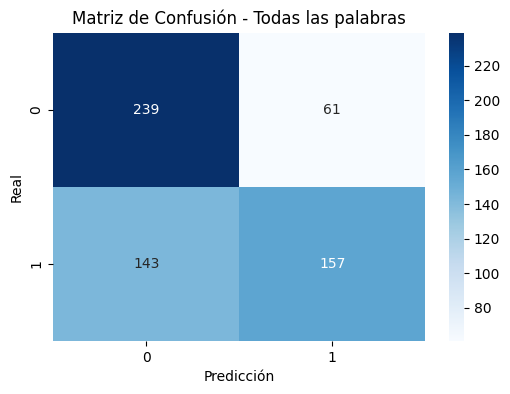

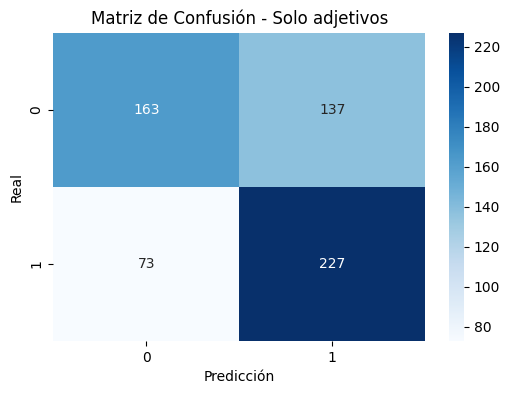

In [94]:
accuracy_all = accuracy_score(y_test, pred_all)
accuracy_adj = accuracy_score(y_test, pred_adjetivos)
print(f"Accuracy considerando todos los POS: {accuracy_all:.2f}")
print(f"Accuracy considerando solo los adjetivos: {accuracy_adj:.2f}")

# Matriz de Confusi√≥n
con_all = confusion_matrix(y_test, pred_all)
con_adj = confusion_matrix(y_test, pred_adjetivos)

plt.figure(figsize=(6, 4))
sns.heatmap(con_all, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusi√≥n - Todas las palabras')
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(con_adj, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusi√≥n - Solo adjetivos')
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.show()


## Ampliaci√≥

Para lograr la ampliaci√≥n de asignar pesos a los POS, primero hemos construido un base de datos de los **scores** caracter√≠sticos de cada documento para entrenar el modelo. Despu√©s ya podremos usar el modelo para predecir.


In [ ]:
# POS relevantes
POS_TAGS = {
    'adj': {'JJ', 'JJR', 'JJS'},
    'verb': {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'},
    'adv': {'RB', 'RBR', 'RBS'},
    'noun': {'NN', 'NNS', 'NNP', 'NNPS'}
}

def extract_pos_sentiment_features(tagged_docs):
    X = []
    for doc in tagged_docs:
        scores = {'adj': 0, 'verb': 0, 'adv': 0, 'noun': 0}
        tokens = [w for w, _ in doc]

        for w, tag in doc:
            pos_category = None
            for key, tag_set in POS_TAGS.items():
                if tag in tag_set:
                    pos_category = key
                    break
            if pos_category:
                syn = lesk(tokens, w)
                if syn:
                    try:
                        senti = swn.senti_synset(syn.name())
                        scores[pos_category] += senti.pos_score() - senti.neg_score()
                    except:
                        pass
        X.append([scores['adj'], scores['verb'], scores['adv'], scores['noun']])
    return np.array(X)

# Extraemos features
X_features = extract_pos_sentiment_features(train_tagged)
y = train_labels

# M√©tricas a evaluar
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': 'f1_macro',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Modelos
modelos = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Resultados
resultados = {}

for nombre, modelo in modelos.items():
    cv_result = cross_validate(modelo, X_features, y, cv=5, scoring=scoring)
    resumen = {m√©trica: round(np.mean(cv_result[f'test_{m√©trica}']), 4) for m√©trica in scoring}
    resultados[nombre] = resumen

# Mostrar tabla de resultados
df_resultados = pd.DataFrame(resultados).T
print("\nüìä Resultados promedio con cross-validation:")
print(df_resultados)

# ENTRENAR FINAL para mostrar importancias
print("\nüéØ Pesos finales entrenando con todo el dataset:")

rf_model = modelos["RandomForest"].fit(X_features, y)

# Importancias RF
print("\nImportancia por feature (RandomForest):")
for i, pos in enumerate(['adj', 'verb', 'adv', 'noun']):
    print(f"{pos}: {rf_model.feature_importances_[i]:.4f}")


üß™ Evaluando RandomForest...

üìä Resultados promedio con cross-validation:
              accuracy  f1_macro  precision_macro  recall_macro
RandomForest    0.6093    0.6089           0.6098        0.6093

üéØ Pesos finales entrenando con todo el dataset:

Importancia por feature (RandomForest):
adj: 0.2969
verb: 0.2318
adv: 0.2391
noun: 0.2322


**Balanceo de Errores**

Aunque el modelo no ha logrado mejorar significativamente el **accuracy**, s√≠ ha conseguido **balancear los errores** entre las clases positivas y negativas. Esto es especialmente importante en problemas donde el desbalance de clases puede llevar a un modelo a favorecer una clase sobre la otra.

En este caso, el modelo ha reducido la cantidad de **falsos positivos** y **falsos negativos**, logrando una distribuci√≥n m√°s equitativa de los errores. Este balance es crucial en aplicaciones donde ambos tipos de errores tienen un impacto significativo, como en el an√°lisis de sentimientos, donde clasificar incorrectamente un sentimiento positivo como negativo (o viceversa) puede llevar a interpretaciones err√≥neas.

Por lo tanto, aunque el **accuracy** no haya mejorado, el modelo es m√°s robusto y confiable al manejar ambos tipos de errores de manera m√°s equilibrada.

Accuracy: 0.64


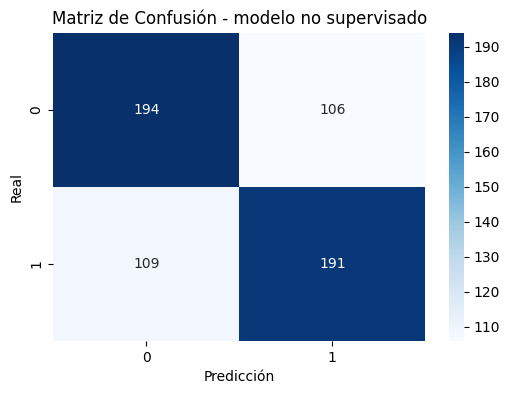

In [ ]:

def predecir_sentimiento_pond(tagged_docs_nuevos, modelo):
    # Extraer los features POS-sentiment
    X_nuevos = extract_pos_sentiment_features(tagged_docs_nuevos)

    # Predecir usando el modelo entrenado
    etiquetas_predichas = modelo.predict(X_nuevos)

    return etiquetas_predichas

# Nuevos documentos POS-tagged
predicciones = predecir_sentimiento_pond(test_tagged, rf_model)

# Accuracy
accuracy = accuracy_score(test_labels, predicciones)
print(f"Accuracy: {accuracy:.2f}")
# Matriz de Confusi√≥n
con = confusion_matrix(test_labels, predicciones)
plt.figure(figsize=(6, 4))
sns.heatmap(con, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matriz de Confusi√≥n - modelo no supervisado')
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.show()


## Comparaci√≥n M√©todos




**Conclusi√≥n**
El modelo SVM podria ser la mejor opci√≥n para este problema, destacando por su precisi√≥n y robustez. Sin embargo, el enfoque no supervisado basado en todos los POS es √∫til como alternativa inicial cuando no se dispone de datos etiquetados.
Tambi√©n hay que destacar como el modelo no supervisado tiene en cuenta los significados y la polaridad de las palabras.


SVM:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85       300
           1       0.85      0.84      0.84       300

    accuracy                           0.84       600
   macro avg       0.85      0.84      0.84       600
weighted avg       0.85      0.84      0.84       600

Modelo no supervisado:
               precision    recall  f1-score   support

           0       0.63      0.80      0.70       300
           1       0.72      0.52      0.61       300

    accuracy                           0.66       600
   macro avg       0.67      0.66      0.65       600
weighted avg       0.67      0.66      0.65       600



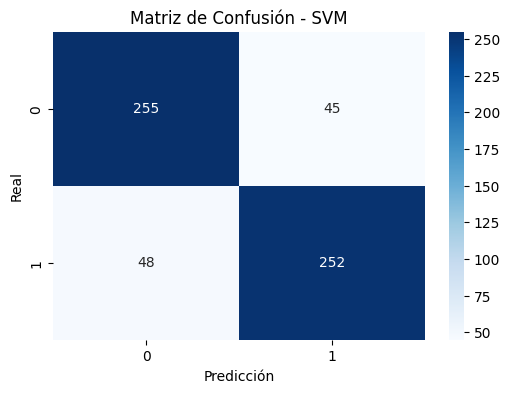

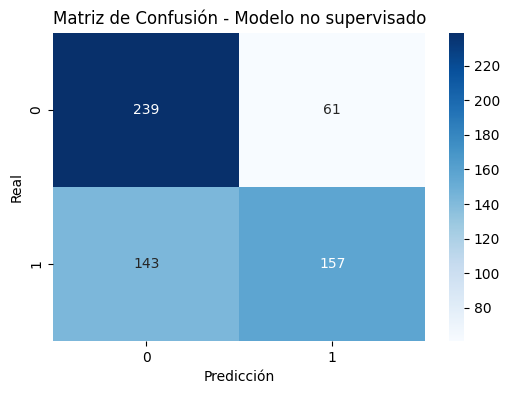

In [96]:
# classification_report de SVM y modelo no supervisado
from sklearn.metrics import classification_report

# SVM
print("SVM:\n", classification_report(y_test, y_pred_svm))

# Modelo no supervisado
print("Modelo no supervisado:\n", classification_report(test_labels, pred_all))

# Matriz de Confusi√≥n
con_svm = confusion_matrix(y_test, y_pred_svm)
con_modelo = confusion_matrix(test_labels, pred_all)

plt.figure(figsize=(6, 4))
sns.heatmap(con_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusi√≥n - SVM')
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.show()

plt.figure(figsize=(6, 4))
sns.heatmap(con_modelo, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusi√≥n - Modelo no supervisado')
plt.xlabel('Predicci√≥n')
plt.ylabel('Real')
plt.show()